# Imports

In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import os
import tqdm
import matplotlib.pyplot as plt
import random
import librosa.display
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from sklearn.metrics import classification_report
from sklearn import metrics


In [56]:
filename = '/kaggle/input/gtzan-genre-collection/genres/pop/pop.00055.au'
y, sr = librosa.load(filename)
label = filename.split('/')[5]

In [57]:
def parser(directory='/kaggle/input'):
    data = [] # Store all data
    labels = [] # Store corresponding labels
    srs = []

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            # Get name
            filename = os.path.join(dirname, filename)
            y, sr = librosa.load(filename)
            label = filename.split('/')[5]

            # Append them to the final data
            data.append(y)
            labels.append(label)
            srs.append(sr)
            
    return data, labels, srs

In [58]:
data, labels, srs = parser(directory='/kaggle/input')

## Plot 2 random waves

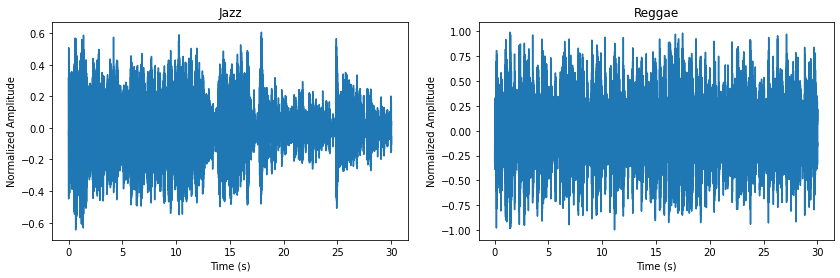

In [59]:
fig, ax = plt.subplots(1,2, figsize=(14,4))

for ax in (ax[0], ax[1]):
    # get a random index
    ind = random.randint(0, len(labels)-1)

    # get timestamps via sampling rate
    times = [sample/srs[ind] for sample in range(len(data[ind]))]

    ax.plot(times, data[ind])
    ax.set(title = labels[ind].capitalize())

    ax.set_ylabel('Normalized Amplitude')
    ax.set_xlabel('Time (s)')

plt.show()

## Genres bar plots

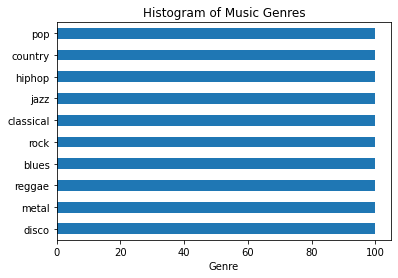

In [60]:
# get the count of each genre
labels_df = pd.DataFrame(labels, columns=['Genres'])
labels_df['Genres'].value_counts().plot.barh()
plt.title('Histogram of Music Genres')
plt.xlabel('Genre')
plt.show()

## Extract mfccs

In [61]:
def get_mfcc(data, srs, n_mfcc):
    '''Gets mfccs given a array like data structure and its sampling rates
    '''
    mfccs = []
    for i in range(len(data)):
        mfcc = librosa.feature.mfcc(y=data[i], sr=srs[i], n_mfcc=n_mfcc).T
        mfccs.append(mfcc)
        
    return mfccs

In [62]:
mfccs = get_mfcc(data, srs, n_mfcc=13)

In [63]:
mfccs[0][:,0].shape[0]

1293

In [64]:
max_length = len(max(mfccs, key=len))

In [65]:
# max_length = 0
# for mfcc in mfccs:
#     length = mfcc[:,0].shape[0]
#     if length > max_length:
#         max_length=length

In [66]:
def pad_mfcc(mfccs, max_length):
    'pads'
    mfccs_padded = []
    for mfcc in mfccs:
        mfcc_padded = np.pad(mfcc, pad_width=[(0,max_length-mfcc[:,0].shape[0]),(0,0)])
        mfccs_padded.append(mfcc_padded)
    return mfccs_padded

In [67]:
mfccs_padded = pad_mfcc(mfccs, max_length)

## Plot Mel-sepctogram and Mfccs

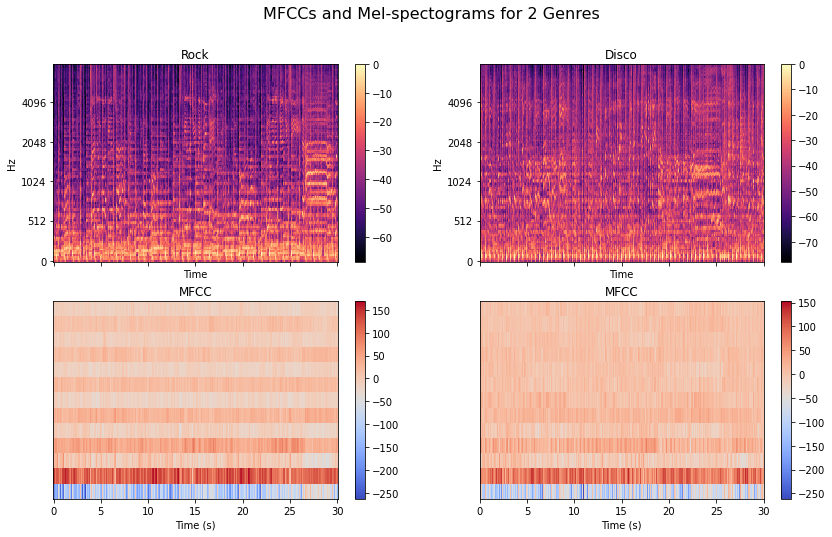

In [68]:
fig, ax = plt.subplots(2,2, figsize=(14,8), sharex=True)

for i in range(2):
    # get a random index
    ind = random.randint(0, len(labels)-1)
    
    # Get mel-spectogram as well
    S = librosa.feature.melspectrogram(y=data[ind], sr=srs[ind], n_mels=128,
                                   fmax=8000)
    
    # Plot mel - spectogram
    img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0,i])
    ax[0,i].set(title = labels[ind].capitalize())
    fig.colorbar(img, ax=ax[0,i])
    
    # Plot MFCC
    img = librosa.display.specshow(mfccs[ind].T, x_axis='time', sr=srs[0], ax=ax[1,i])
    ax[1,i].set(title = 'MFCC')
    
    fig.colorbar(img, ax=ax[1,i])
    ax[1,i].set_xlabel('Time (s)')

fig.suptitle('MFCCs and Mel-spectograms for 2 Genres', fontsize=16)
plt.show()

## Plot histograms of the 1st and 2nd MFCC for two different Genres
Using all the data for each Genre.

In [69]:
def find_indices(list_to_check, item_to_find):
    # Find the indices of a specific value on a list
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

In [70]:
def plot_hist(mfccs_padded, genres, labels):
    """Plots histogram of given digits
       Args:
           mfcc (list)
           genres (list): list containing genres (str) you want to plot (if you want more than 2 genres it needs changes)
           labels (list): List containing the names of the files.
       """    
    ind_metal = find_indices(labels, genres[0])
    ind_classical = find_indices(labels, genres[1])

    metal_mfccs = [mfccs_padded[i] for i in ind_metal]  # Get mfccs for all the values for first digit
    classical_mfccs = [mfccs_padded[i] for i in ind_classical]  # Get mfccs for all the values for second digit

    # Define a starting value for the loop below
    metal_mfccs_ = metal_mfccs[0]
    classical_mfccs_ = classical_mfccs[0]

    for i in range(len(ind_metal) - 1):
        # Combining all the MFCCS for each digit (For every sample of that digit)
        metal_mfccs_ = np.concatenate((metal_mfccs_, metal_mfccs[i + 1]), axis=0)  # For the 1st digit
        classical_mfccs_ = np.concatenate((classical_mfccs_, classical_mfccs[i + 1]), axis=0)  # For the 2nd digit

    # Defining the bins for the Histograms
    bins = np.linspace(min(min(metal_mfccs_[:, 0]), min(classical_mfccs_[:, 0])),
                       max(max(metal_mfccs_[:, 0]), max(classical_mfccs_[:, 0])), 20)
    bins2 = np.linspace(min(min(metal_mfccs_[:, 1]), min(classical_mfccs_[:, 1])),
                        max(max(metal_mfccs_[:, 1]), max(classical_mfccs_[:, 1])), 20)


    # Plotting the histograms
    fig = plt.figure(figsize=(15, 5))

    # 1st MFCC
    plt.subplot(1, 2, 1)
    plt.hist(metal_mfccs_[:, 0], bins, alpha=0.7, color='navy', edgecolor='black', linewidth=1.2,
             label=genres[0].capitalize())
    plt.hist(classical_mfccs_[:, 0], bins, alpha=0.7, color='darkgray', edgecolor='black', linewidth=1.2,
             label=genres[1].capitalize())
    plt.title('1st MFCC')
    plt.legend(loc=4)

    # 2nd MFCC
    plt.subplot(1, 2, 2)
    plt.hist(metal_mfccs_[:, 1], bins2, alpha=0.7, color='navy', edgecolor='black', linewidth=1.2,
             label=genres[0].capitalize())
    plt.hist(classical_mfccs_[:, 1], bins2, alpha=0.7, color='darkgray', edgecolor='black', linewidth=1.2,
             label=genres[1].capitalize())
    plt.title('2nd MFCC')
    plt.legend(loc=4)

    plt.legend(loc=4)
    plt.suptitle(f'MFCC Coefficient for Metal and Classical')
    plt.show()

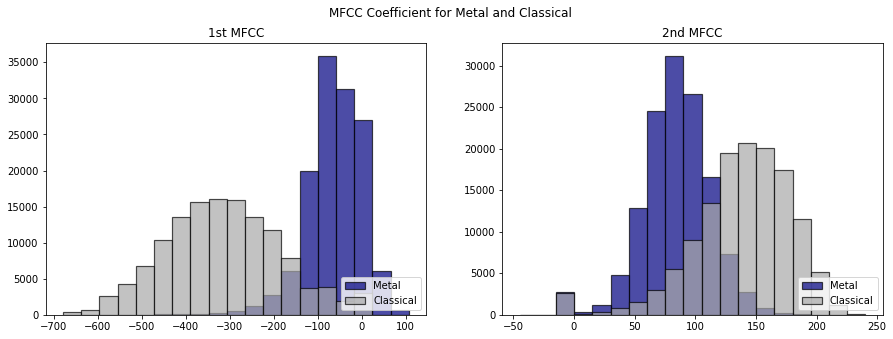

In [71]:
plot_hist(mfccs_padded, genres=['metal','classical'], labels=labels)

In [72]:
def corr_matrices(y, genres, name_list, corr=True):
    """Calculates the MFCCS and the correlation matrices for specified Genre
               Args:
                   y (np.ndarray): MFCCs
                   genres (list): list containing strings for ex. 'metal'
                   name_list (list): list containing names of files for ex. 'metal' (labels)
                   corr (Boolean): True if you want the correlation matrices
               Returns:
                   mfccs_1_1 (np.ndarray): containing mfscs matrix for the first genre and first element
                   mfccs_1_2 (np.ndarray): containing mfscs matrix for the first genre and second element
                   mfccs_2_1 (np.ndarray): containing mfscs matrix for the second genre and first element
                   mfccs_2_2 (np.ndarray): containing mfscs matrix for the second genre and second element
               """
    first_genre_indeces = find_indices(name_list, genres[0])  # Get indeces for first genre
    second_genre_indeces = find_indices(name_list, genres[1])

    # Get MFSCS for the given digits and speakers
    mfccs_1_1 = y[first_genre_indeces[0]]
    mfccs_1_2 = y[first_genre_indeces[1]]
    mfccs_2_1 = y[second_genre_indeces[0]]
    mfccs_2_2 = y[second_genre_indeces[1]]

    if corr:
        # if corr is True then get the correlation matrices
        mfccs_1_1 = np.corrcoef(mfccs_1_1.T)
        mfccs_1_2 = np.corrcoef(mfccs_1_2.T)
        mfccs_2_1 = np.corrcoef(mfccs_2_1.T)
        mfccs_2_2 = np.corrcoef(mfccs_2_2.T)

    return mfccs_1_1, mfccs_1_2, mfccs_2_1, mfccs_2_2

In [73]:
def plot_correlation_matrix(y1, y2, y3, y4, genre, method):
    # Plotting the correlation matrices
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 8))
    
    counter = 0
    for ax, y, temp in zip([ax1, ax2, ax3, ax4],[y1, y2, y3, y4],['1st','2nd','1st','2nd']):
        pic = ax.matshow(y)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(pic, cax=cax, orientation='vertical')
        
        if counter in [0,1]:
            ind = 0
        else:
            ind = 1
            
        ax.set_title(f'{temp} {method} of Genre {genre[ind]}')
        counter +=1
        
    plt.show()

## Get correlation matrices

In [74]:
mfccs_1_1, mfccs_1_2, mfccs_2_1, mfccs_2_2 = corr_matrices(mfccs_padded, genres=['metal','classical'], name_list=labels, corr=True)

## Plot Correlation matrices

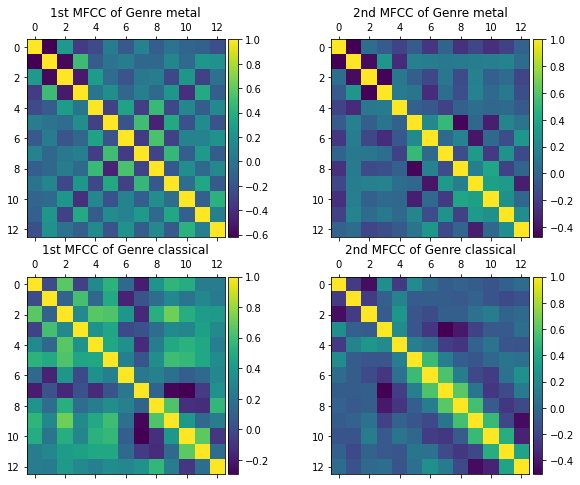

In [75]:
plot_correlation_matrix(mfccs_1_1, mfccs_1_2, mfccs_2_1, mfccs_2_2, genre=['metal','classical'], method='MFCC')

# Put Data in DataLoaders

mfccs_padded  labels

In [76]:
# convert data to numpy array
X = np.asarray(mfccs_padded)  

### Mapping labels

In [77]:
codes = {
    'blues':0,
    'classical':1,
    'country':2,
    'disco':3,
    'hiphop':4,
    'jazz':5,
    'metal':6,
    'pop':7,
    'reggae':8,
    'rock':9
}

df_map = pd.DataFrame (labels, columns = ['labels'])
df_map['labels'] = df_map['labels'].map(codes)
y = df_map['labels'].to_numpy()

In [78]:
def train_val_test_split(x, y, test_size, val_size, random_state=None, stratify=None):
    x_t, x_test, y_t, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=stratify)
    if stratify is not None:
        stratify = y_t
    x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=val_size, random_state=random_state, stratify=stratify)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

def to_Dataloader(x_train, y_train, x_val, y_val, x_test, y_test, batch_size, test_batch=1,shuffle=True):
    x_train_t = torch.Tensor(x_train) # transform to torch tensor
    y_train_t = torch.Tensor(y_train).type(torch.LongTensor) # transform to torch tensor
    x_val_t = torch.Tensor(x_val) # transform to torch tensor
    y_val_t = torch.Tensor(y_val).type(torch.LongTensor) # transform to torch tensor
    x_test_t = torch.Tensor(x_test) # transform to torch tensor
    y_test_t = torch.Tensor(y_test).type(torch.LongTensor) # transform to torch tensor
    
    train_dataset = TensorDataset(x_train_t,y_train_t) # create your datset
    val_dataset = TensorDataset(x_val_t,y_val_t) # create your datset
    test_dataset = TensorDataset(x_test_t,y_test_t) # create your datset
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle) # create your dataloader
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle) # create your dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=shuffle) # create your dataloader
    
    return train_dataloader, val_dataloader, test_dataloader

### Get the Data into DataLoaders

In [79]:
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(X, y, test_size=0.2, val_size=0.2, random_state=42, stratify=y)

train_dataloader, val_dataloader, test_dataloader = to_Dataloader(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, test_batch=1,shuffle=True)

### Early stop class
from: 'https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py'

In [80]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# CNN implementation

In [81]:
class CNN(nn.Module):
    def __init__(self, input_features, input_timesteps, conv_channels, kernels, maxpools, lin_channels, dropout):
        super(CNN, self).__init__()
        self.num_conv_layers = len(kernels)

        seq = []
        for i in range(self.num_conv_layers):
            seq.append(nn.Conv2d(in_channels=conv_channels[i], 
                                 out_channels=conv_channels[i+1],
                                 kernel_size=kernels[i], stride=1, padding=1))
            seq.append(nn.ReLU())
            seq.append(nn.BatchNorm2d(num_features=conv_channels[i+1],track_running_stats=False))
            seq.append(nn.MaxPool2d(kernel_size=maxpools[i]))


        # Flatten the output of the final convolution layer
        seq.append(nn.Flatten())

        convolutions = nn.Sequential(*seq)

        # Calculation of first linear layer dimensions
        # We build an empty tensor of appropriate size and let him go through
        # the above sequence, in order to calculate the output's size automatically
        first_lin = convolutions(torch.empty(1,conv_channels[0],input_timesteps,input_features)).size(-1)

        self.num_lin_layers = len(lin_channels)
        for i in range(self.num_lin_layers):
            if i == self.num_lin_layers-1:
                seq.append(nn.Linear(lin_channels[i-1], lin_channels[i]))
                break
            elif i == 0:
                seq.append(nn.Linear(first_lin, lin_channels[i]))
            else:
                seq.append(nn.Linear(lin_channels[i-1], lin_channels[i]))
                
            seq.append(nn.ReLU())
            seq.append(nn.Dropout(dropout)) # Dropout

        self.fitter = nn.Sequential(*seq)

    def forward(self, x):

        x = x.transpose(1,2)
        x.unsqueeze_(1)
        out = self.fitter(x)
        return out

## Train function

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [83]:
def training_loop(model, train_dataloader, optimizer, device=device):

    model.train() # Sets model to train mode
    batch_losses = []

    for x_batch, y_batch in train_dataloader:
        # Move batches to device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Clear gradients
        optimizer.zero_grad()

        yhat = model(x_batch)  #predictions on x
        
        # Forward pass
        loss = loss_function(yhat, y_batch)
        
        # Backward and optimize
        loss.backward()

        # Update parameters
        optimizer.step()

        batch_losses.append(loss.data.item())

    train_loss = np.mean(batch_losses)

    return train_loss  # Return train_loss and anything else you need

In [84]:
def validation_loop(model, val_dataloader, device=device):

    model.eval() # Sets model to val mode

    batch_losses = []

    for x_batch, y_batch in val_dataloader:

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        yhat = model(x_batch)  #predictions on x
        
        loss = loss_function(yhat, y_batch)

        batch_losses.append(loss.data.item())

    val_loss = np.mean(batch_losses)

    return val_loss

In [85]:
def train(model, train_dataloader, val_dataloader, optimizer, epochs, device="cuda", patience = None, temp=100):

    train_losses = []
    val_losses = []

    print(f"Initiating training.")
    
    # Check if early stop is enabled:
    if patience is not None:
        # Initialize EarlyStopping
        early_stopping = EarlyStopping(patience=patience, verbose=False, path='checkpoint.pt')

    for epoch in range(epochs):
        # Training loop

        train_loss = training_loop(model, train_dataloader, optimizer, device)
        train_losses.append(train_loss)

        # Validation loop
        with torch.no_grad():

            val_loss = validation_loop(model, val_dataloader, device)
            val_losses.append(val_loss)

        if patience != -1:
            early_stopping(val_loss, model)

            if early_stopping.early_stop:
                print("Early stop. Going back to the last checkpoint.")
                break

        if epoch % temp == 0:
            print(f"[{epoch}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")

    if patience != None and early_stopping.early_stop == True:
        print('Loading model from checkpoint...')
        model.load_state_dict(torch.load('checkpoint.pt'))
        print('Checkpoint loaded.')

    print("training finished.")
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

    # find position of lowest validation loss
    minposs = val_losses.index(min(val_losses)) + 1
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, max(val_losses + train_losses))  # consistent scale
    plt.xlim(0, len(train_losses) + 1)  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.title('Validation and Training Loss of CNN')
    plt.show()

    return model

In [86]:
def overfit(model, train_dataloader, n_epochs = 2500, temp=10):

    num_batches = 1 
    batches = []

    for i in range(num_batches):
        batch = next(iter(train_dataloader))
        batches.append(batch)

    train_losses = []

    for epoch in range(n_epochs):

        model.train()
        batch_losses = []

        for batch in batches:

            x_batch, y_batch = batch

            # Move to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Clear the previous gradients first
            optimizer.zero_grad()

            yhat = model(x_batch) 

            # loss calculation
            loss = loss_function(yhat, y_batch)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            batch_losses.append(loss.data.item())
            
        train_loss = np.mean(batch_losses)
        
        if epoch % temp == 0:
            print(f"[{epoch}/{n_epochs}] Training loss: {train_loss:.4f}")
            
        train_losses.append(train_loss)
        
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, max(train_losses))  # consistent scale
    plt.xlim(0, len(train_losses) + 1)  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.title('Training Loss of CNN using single Batch training')
    plt.show()

    return model

## Predict Function

In [87]:
def predict(model, test_loader, n_features, loss_function, device=device):
    # Make predictions using model
    preds = []
    true_values = []
    loss = 0
    model.eval()  # prep model for evaluation
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            # move to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Make predictions
            pred = model(x_batch)
            
            preds.append(np.argmax(pred.cpu().numpy(), axis=1)[0])
            true_values.append(y_batch.cpu().numpy()[0])
            loss += loss_function(pred, y_batch)

        #Calculate Accuracy
        accuracy = sum(np.array(preds) == np.array(true_values))/len(true_values)
        
    return preds, true_values, accuracy

### Confusion matrix

### Initiliaze model

In [88]:
model = CNN(input_features=13, input_timesteps=1320, conv_channels=[1,4,16,32,64], kernels=[2,2,2,2], maxpools=[2,2,2,2], lin_channels=[1320,10], dropout=0)
model.to(device)

CNN(
  (fitter): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=F

### Overfit model
Just to be sure model is training as it should

In [89]:
learning_rate = 0.001
weight_decay = 1e-6


loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

[0/100] Training loss: 2.4211


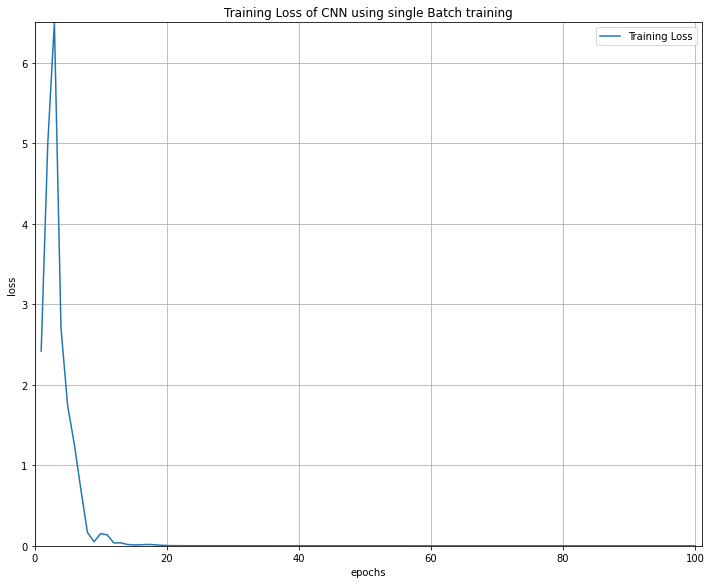

In [90]:
model = overfit(model, train_dataloader, n_epochs = 100, temp=100)

## Train model

## Get data into DataLoaders

In [122]:
batch_size=64

x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(X, y, test_size=0.15, val_size=0.15, random_state=None, stratify=y)

train_dataloader, val_dataloader, test_dataloader = to_Dataloader(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=batch_size, test_batch=1,shuffle=True)

In [129]:
model = CNN(input_features=13, input_timesteps=1320, conv_channels=[1,4,16,64,128], kernels=[2,2,2,2], maxpools=[2,2,2,2], lin_channels=[1000,128,10], dropout=0.5)
model.to(device)

CNN(
  (fitter): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [130]:
learning_rate = 0.0001
weight_decay = 1e-4


loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

Initiating training.
[0/1000] Training loss: 2.1384	 Validation loss: 1.8640.
[5/1000] Training loss: 1.4246	 Validation loss: 1.3467.
[10/1000] Training loss: 0.8077	 Validation loss: 1.1287.
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 1 out of 15
[15/1000] Training loss: 0.4127	 Validation loss: 1.0698.
EarlyStopping counter: 2 out of 15
EarlyStopping counter: 3 out of 15
EarlyStopping counter: 4 out of 15
EarlyStopping counter: 1 out of 15
[20/1000] Training loss: 0.1833	 Validation loss: 1.1051.
EarlyStopping counter: 2 out of 15
EarlyStopping counter: 3 out of 15
EarlyStopping counter: 4 out of 15
EarlyStopping counter: 5 out of 15
EarlyStopping counter: 6 out of 15
[25/1000] Training loss: 0.0965	 Validation loss: 1.1304.
EarlyStopping counter: 7 out of 15
EarlyStopping counter: 8 out of 15
EarlyStopping counter: 9 out of 15
EarlyStopping counter: 10 out of 15
EarlyStopping counter: 11 out of 15
[30/1000] Training loss: 0.0560	 Validation loss: 1.1322.
EarlyStopping

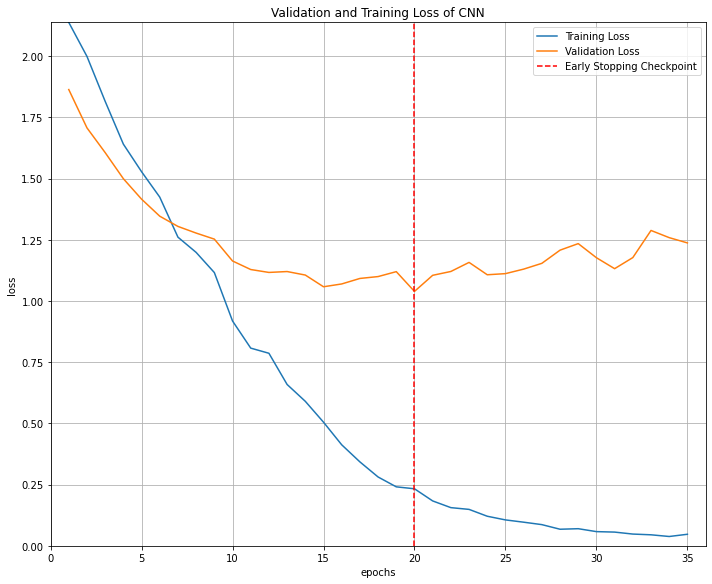

In [131]:
model = train(model, train_dataloader, val_dataloader, optimizer, epochs=1000, device="cuda", patience = 15, temp=5)

In [132]:
preds, true_values, accuracy = predict(model, test_dataloader, n_features=13, loss_function=loss_function, device=device)

In [133]:
print(classification_report(true_values, preds))

              precision    recall  f1-score   support

           0       0.33      0.27      0.30        15
           1       0.00      0.00      0.00        15
           2       0.28      0.60      0.38        15
           3       0.43      0.40      0.41        15
           4       0.33      0.33      0.33        15
           5       0.32      0.47      0.38        15
           6       1.00      0.13      0.24        15
           7       0.00      0.00      0.00        15
           8       0.28      0.73      0.40        15
           9       0.15      0.13      0.14        15

    accuracy                           0.31       150
   macro avg       0.31      0.31      0.26       150
weighted avg       0.31      0.31      0.26       150



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train model with more features and compare

### Get 40 mfccs

In [97]:
mfccs_l = get_mfcc(data, srs, n_mfcc=40)

In [98]:
mfccs_l[0][:,0].shape[0]

1293

In [99]:
max_length_l = len(max(mfccs_l, key=len))

In [100]:
mfccs_padded_l = pad_mfcc(mfccs_l, max_length_l)

### Get Data to Dataloaders

In [101]:
# convert data to numpy array
X_l = np.asarray(mfccs_padded_l)  

In [109]:
batch_size=64

x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(X_l, y, test_size=0.15, val_size=0.15, random_state=None, stratify=y)

train_dataloader, val_dataloader, test_dataloader = to_Dataloader(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=batch_size, test_batch=1,shuffle=True)

### Train and evaluate model

In [110]:
model_l = CNN(input_features=40, input_timesteps=1320, conv_channels=[1,4,16,64,128], kernels=[4,4,4,4], maxpools=[2,2,2,2], lin_channels=[1000,128,10], dropout=0.5)
model_l.to(device)

CNN(
  (fitter): Sequential(
    (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [111]:
learning_rate = 0.0001
weight_decay = 1e-4


loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_l.parameters(), lr = learning_rate, weight_decay = weight_decay)

Initiating training.
[0/1000] Training loss: 2.2317	 Validation loss: 1.9230.
[5/1000] Training loss: 1.0842	 Validation loss: 1.1504.
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 1 out of 15
[10/1000] Training loss: 0.4605	 Validation loss: 0.9816.
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 2 out of 15
EarlyStopping counter: 3 out of 15
EarlyStopping counter: 4 out of 15
[15/1000] Training loss: 0.1453	 Validation loss: 0.9796.
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 2 out of 15
EarlyStopping counter: 3 out of 15
EarlyStopping counter: 4 out of 15
EarlyStopping counter: 5 out of 15
[20/1000] Training loss: 0.0578	 Validation loss: 1.0443.
EarlyStopping counter: 6 out of 15
EarlyStopping counter: 7 out of 15
EarlyStopping counter: 8 out of 15
EarlyStopping counter: 9 out of 15
EarlyStopping counter: 10 out of 15
[25/1000] Training loss: 0.0411	 Validation loss: 1.0720.
EarlyStopping counter: 11 out of 15
EarlyStopping counter: 12 out of 15


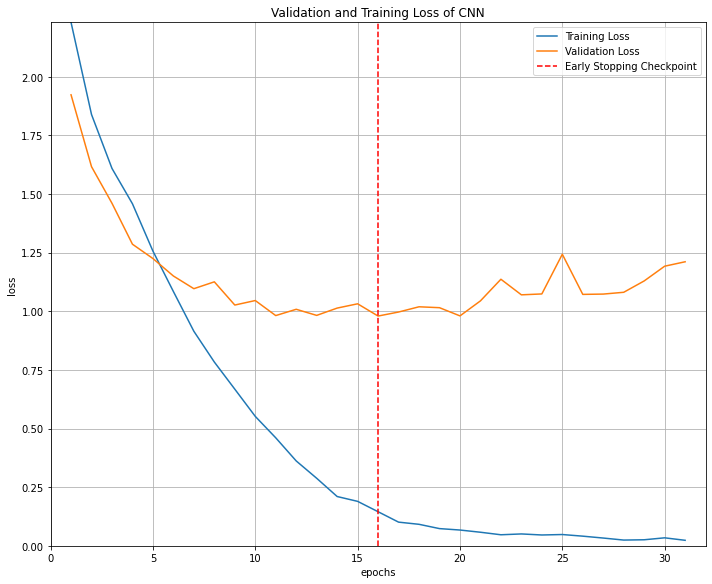

In [112]:
model_l = train(model_l, train_dataloader, val_dataloader, optimizer, epochs=1000, device="cuda", patience = 15, temp=5)

In [113]:
preds_l, true_values_l, accuracy = predict(model_l, test_dataloader, n_features=40, loss_function=loss_function, device=device)

In [114]:
print(classification_report(true_values_l, preds_l))

              precision    recall  f1-score   support

           0       0.29      0.33      0.31        15
           1       0.00      0.00      0.00        15
           2       0.50      0.33      0.40        15
           3       0.25      0.07      0.11        15
           4       1.00      0.07      0.12        15
           5       0.43      1.00      0.60        15
           6       1.00      0.07      0.12        15
           7       0.89      0.53      0.67        15
           8       0.39      0.73      0.51        15
           9       0.22      0.67      0.33        15

    accuracy                           0.38       150
   macro avg       0.50      0.38      0.32       150
weighted avg       0.50      0.38      0.32       150



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plot confusion Matrices

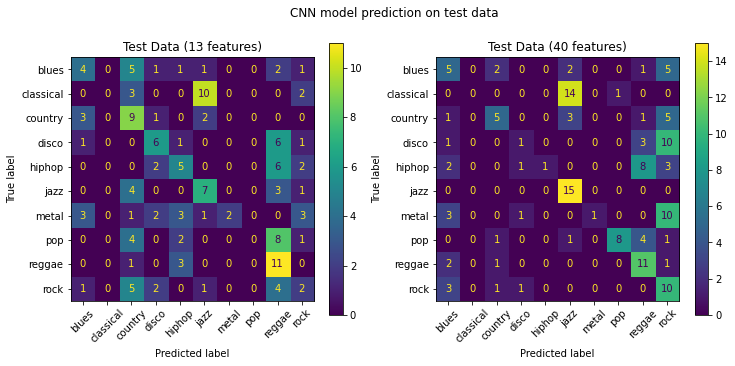

In [134]:
classlist = list(codes.keys())

# Plotting confusion matrices for small and big data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Set up the figure
ax = ax.ravel()

y_ = [true_values, true_values_l]
preds_lst = [preds, preds_l]
titles = ['Test Data (13 features)', 'Test Data (40 features)']
for i in range(2):
    actual = y_[i]
    predicted =preds_lst[i]  # get the prediction for each model (each loop)

    confusion_matrix = metrics.confusion_matrix(np.array(actual), np.array(predicted))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm_display.plot(ax=ax[i])
    ax[i].set_xticklabels(classlist, rotation=45)
    ax[i].set_yticklabels(classlist)
    ax[i].set_title(titles[i])

fig.suptitle('CNN model prediction on test data')
plt.show()